In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import SymLogNorm
from matplotlib.patches import Ellipse
from matplotlib import gridspec
import scienceplots
import warnings
import h5py

import ppxf.ppxf_util as util

from astropy.utils.exceptions import AstropyWarning
import astropy.units as u
from astropy import constants
from astropy.table import Table
from astropy.coordinates import SkyCoord,FK5,ICRS
from astropy.io import fits,ascii
from astropy.wcs import WCS, utils as wcsutils
from astropy.stats import sigma_clipped_stats
import astropy.visualization as vis
from astropy.cosmology import Planck18
from astropy.modeling import models, fitting,polynomial
import astropy.modeling as modeling
from astropy.nddata import StdDevUncertainty, Cutout2D
from astropy.convolution import Gaussian2DKernel,Gaussian1DKernel

from photutils.aperture import EllipticalAperture, SkyEllipticalAperture
from photutils.psf import PSFPhotometry,FittableImageModel,IterativePSFPhotometry
from photutils.detection import DAOStarFinder
from photutils.background import LocalBackground, MMMBackground
from astropy.table import QTable

import os, sys, glob, pdb
os.environ["SPS_HOME"]="/disk/bifrost/yuanze/software/fsps"

from importlib import reload
from reproject import reproject_interp
from regions import Regions
import os, sys, glob, pdb, re
sys.path.append('/disk/bifrost/yuanze/KBSS/CubEx_run/scripts')
sys.path.append('/disk/bifrost/yuanze/software/GalfitS/src')
import importlib
import run_cubetools_v1 as ctools
from importlib import reload
from reproject import reproject_interp
from regions import Regions


Found: ['q1549_irac_ch2_mosaic.fits']
reading: /disk/bifrost/yuanze/KBSS/kbss_irac/Q1549/q1549_irac_ch2_mosaic.fits


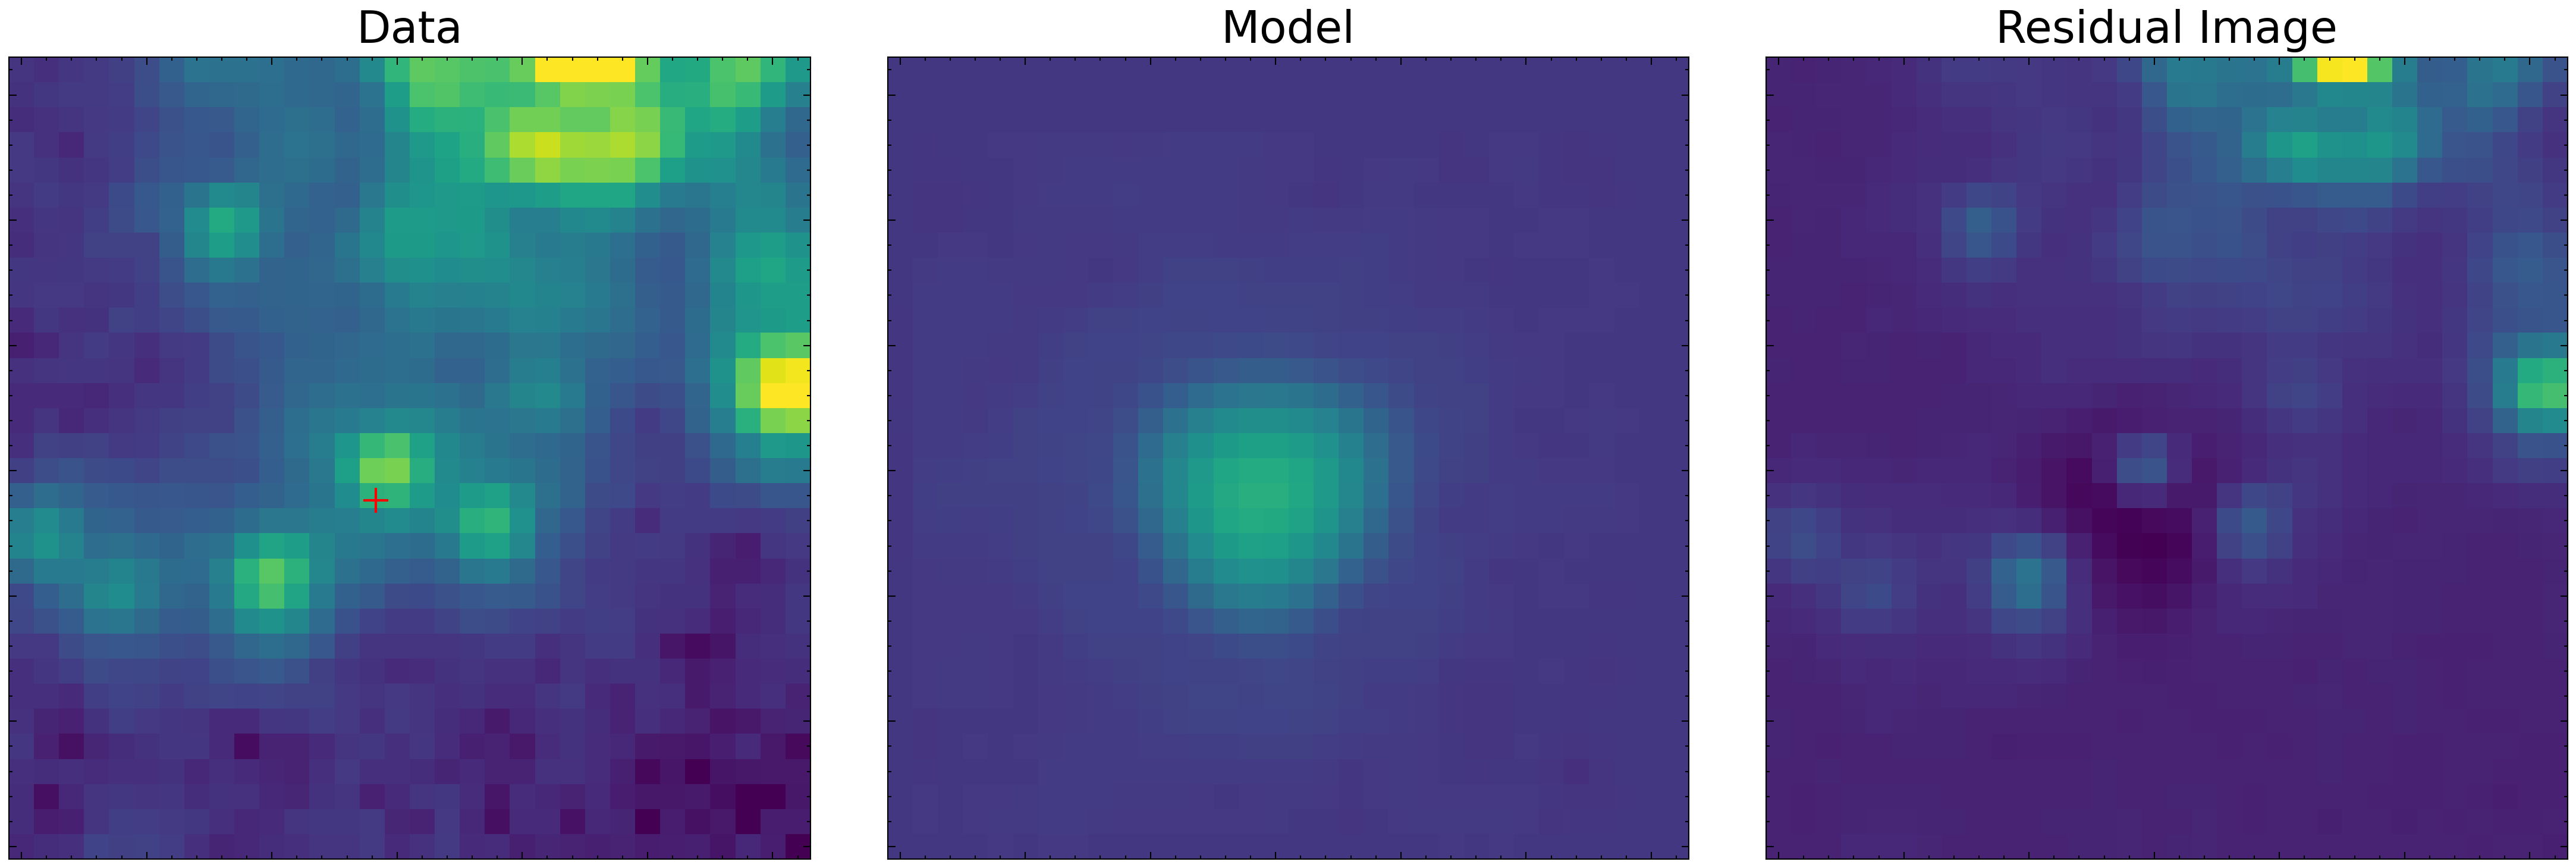

In [38]:
KBSSpath="/disk/bifrost/yuanze/KBSS"
source_table = ascii.read(KBSSpath+"/KCWI/KBSS_faint_AGN.list",format="ipac")
filters = ["table['KCWI'] == 'yes'","table['Field']=='Q1549'","table['Name']=='MD10'","table['Name']!='Lab5'","table['Name']!='FSzP1170'"]
dtype="KBSS"
all_directories,qsotab,all_data_dir = ctools.find_directories_from_ascii(source_table, KBSSpath,filters=filters,KBSS=(dtype=="KBSS"),channel="blue")

datatype="spitzer"
inst="ch2"
filter_name="ch2"

write_cutimg=True
generate_PSF=False
for ind,sentry in enumerate(qsotab):
    field=sentry["Field"]
    sname=sentry["Name"]
    ra = sentry["RA"]
    dec = sentry["Decl"]
    subdapath=all_directories[ind].replace("kcwib",datatype)
    if not os.path.exists(subdapath):
        os.makedirs(subdapath)
    sc = SkyCoord(ra=ra,dec=dec,unit="deg")
    matches=[]
    if datatype == "hst":
        pattern = re.compile(r"^{}.*.{}.fits$".format(field,filter_name), re.IGNORECASE)
        datapath=KBSSpath+"/"+field+"/"+datatype

        for fname in os.listdir(datapath):
            if pattern.match(fname):
                matches.append(fname)
        print("Found:",matches)
        print("reading:",datapath+"/"+matches[0])
        #fprefix = datapath.split("/")[-1]
        #fname = datapath+"/"+fprefix+"_drc.fits"
        #outname = datapath+"/"+fprefix
        outname=subdapath+"/"+matches[0].replace(".fits","")
        hdu = fits.open(outname+'_cutimg.fits')
        #cfac=1.
        #img = IM.image(datapath+"/"+matches[0],hdu=0,unit="electron")
    elif datatype == "spitzer":
        if "ch" in inst:
            tel="irac"
            postfix="mosaic"
        else:
            tel="mips"
            postfix=""
        datapath = KBSSpath+f"/kbss_{tel}/{field}"
        matches=[]
        if field=="GWS":
            pattern = re.compile(r'^CDS_EGS.*.{}.*{}.fits$'.format(inst,"ima_v24lin"), re.IGNORECASE)
        elif field=="LyC22":
            pattern = re.compile(r'^ssa22.*.{}.*{}.fits$'.format(inst,postfix), re.IGNORECASE)
        else:
            pattern = re.compile(r'^{}.*.{}.*{}.fits$'.format(field,inst,postfix), re.IGNORECASE)
        
        for fname in os.listdir(datapath):
            if pattern.match(fname):
                matches.append(fname)
        print("Found:",matches)
        print("reading:",datapath+"/"+matches[0])
        if field=="GWS":
            covhdu = fits.open(datapath+"/"+matches[0].replace("ima","tim"))
        else:
            covhdu = fits.open(datapath+"/"+matches[0].replace("mosaic","cov"))
        #img = IM.image(datapath+"/"+matches[0],hdu=0,unit="MJy/sr")
        outname=subdapath+"/"+matches[0].replace("_mosaic.fits","")
        #hdu = fits.open(datapath+"/"+matches[0])
        #hdu = fits.open(outname+'_cut.fits')
    hdu = fits.open(outname+'_cut.fits')
    imdata = fits.open(outname+'_cut.fits')[0].data
    #sky_mean, sky_median, sky_std = sigma_clipped_stats(imdata, sigma=3)

    error= fits.open(outname+'_cut.fits')[2].data
    mask= fits.open(outname+'_cut.fits')[1].data>0
    psfim = fits.open(datapath+f"/{datatype}_{inst}_epsf.fits")[0].data
    psf_model = FittableImageModel(psfim)
    wcsinfo=WCS(hdu[0].header)
    
    bkgstat = MMMBackground()
    localbkg_estimator = LocalBackground(5, 15, bkgstat)

    fit_shape = [5,5]
    finder = DAOStarFinder(6.0, 2.0)
    #Do iterative PSF photometry
    psfphot = PSFPhotometry(psf_model, fit_shape,localbkg_estimator=localbkg_estimator,# finder=finder,
                            aperture_radius=2,fitter_maxiters=1000)

    init_params = QTable()

    xini=[]
    yini=[]
    #for ind,RA in enumerate(sentry["RA"].value):
    sc = SkyCoord(ra=ra, dec=dec, unit='deg',frame="icrs", equinox='J2000')
    s_coord=wcsinfo.world_to_pixel(sc)
    xini.append(s_coord[0].flatten()[0])
    yini.append(s_coord[1].flatten()[0])
    init_params['x'] = xini
    init_params['y'] = yini

    phot = psfphot(imdata, error=error,mask=mask.astype("bool"),init_params=init_params)
    
    plt.style.use(["science",'no-latex'])
    plt.rcParams.update({
        "font.family": "dejavu sans",   # specify font family here
        "font.serif": ["Times"],  # specify font here
        "font.size":15,
    "legend.fancybox":True})


    resid = psfphot.make_residual_image(imdata, (49, 49))
    resid -= np.mean(phot["local_bkg"])
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5),dpi=300)
    norm = vis.simple_norm(imdata, 'sqrt', percent=99)
    ax[0].imshow(imdata, origin='lower', norm=norm)
    ax[1].imshow(imdata - resid, origin='lower', norm=norm)
    im = ax[2].imshow(resid, origin='lower')
    ax[0].set_title('Data')
    ax[1].set_title('Model')
    ax[2].set_title('Residual Image')


    x0, y0 = 30, 30
    arrow_length = 15/3600

    # Convert pixel coordinates to sky coordinates (RA, Dec)
    sky_coords = wcsinfo.pixel_to_world(x0, y0)
    ra, dec = sky_coords.ra.deg, sky_coords.dec.deg

    # Define the end points of the arrows in pixel coordinates
    north_end = wcsinfo.world_to_pixel_values(ra, dec + arrow_length)
    east_end = wcsinfo.world_to_pixel_values(ra - arrow_length, dec)


    # Calculate the direction vectors for the arrows
    north_vector = [north_end[0] - x0, north_end[1] - y0]
    east_vector = [east_end[0] - x0, east_end[1] - y0]

    # Plot the North arrow
    #ax[0].quiver(x0, y0, north_vector[0], north_vector[1], angles='xy', scale_units='xy', scale=1, color='w')
    #ax[0].text(x0 + north_vector[0]/2, y0 + north_vector[1]/2, 'N', color='w', ha='center', va='bottom')

    # Plot the East arrow
    #ax[0].quiver(x0, y0, east_vector[0], east_vector[1], angles='xy', scale_units='xy', scale=1, color='w')
    #ax[0].text(x0 + east_vector[0]/2+5, y0 + east_vector[1]/2, 'E', color='w', ha='center', va='top')
    #ax[0].text(0.1,0.9,"{}".format(filter_name),transform=ax[0].transAxes,color="w")

    for ent in phot["x_fit","y_fit"]:
        ax[0].plot(ent["x_fit"], ent["y_fit"],"+",c="r",ms=10,lw=0.1)
    for axx in ax:
        axx.set_xticklabels([])
        axx.set_yticklabels([])
    #fig.savefig(multiAGNpath+"/"+field+"/fig/{}_{}_{}.pdf".format(datatype,inst.split("/")[0],inst.split("/")[1]))
    plt.tight_layout()

In [39]:
phot

id,group_id,local_bkg,x_init,y_init,flux_init,x_fit,y_fit,flux_fit,x_err,y_err,flux_err,npixfit,group_size,qfit,cfit,flags
int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,int64
1,1,0.017284804288007265,15.110187360662671,15.558416502012264,0.9902033903785089,14.146842379232881,13.815412037421103,3.720436889204879,0.6493715034894657,0.4473177971554135,0.45444956823827165,25,1,3.3085152334180763,0.346946010619332,0


In [36]:
fits.open(outname+'_cut.fits')[1].data

array([[0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 1.0040336, 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 1.0040336, 1.0040336,
        0.       ],
       [0.       , 0.       , 0.       , ..., 1.0040336, 1.0040336,
        1.0040336]], shape=(32, 32), dtype='>f4')